In [2]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from itertools import product
import numpy as np

from tqdm import tqdm
from sklearn.svm import SVC

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms

In [4]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

sys.path.append(parent_dir)

from utils import AddGaussianNoise, AddImpulseNoise

# Model Defintion: SmallCNN

A SGD classifer is not enough to get reliable insights on CIFAR-10 dataset so we will use a lightweight CNN. This will allow us to accurately estimate the influence of training order

In [5]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# MNIST Dataset (Vanilla Case)

## Data Loading

As MNIST consist of grayscale images, we can define 1 channel of size 28x28.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

base_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
base_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = torch.stack([base_train[i][0] for i in range(len(base_train))])
y_train = torch.tensor([base_train[i][1] for i in range(len(base_train))])

X_test = torch.stack([base_test[i][0] for i in range(len(base_test))])
y_test = torch.tensor([base_test[i][1] for i in range(len(base_test))])

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

X_train: torch.Size([60000, 1, 28, 28]), y_train: torch.Size([60000])
X_test: torch.Size([10000, 1, 28, 28]), y_test: torch.Size([10000])


## Analysis

### (0) Base Case

Let's try as the Vanilla Base Case: Train on the entire dataset using uniform random shuffling for each epoch.

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_loss:.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Using device: cpu
Epoch 1/1 - Train Loss: 0.1424
Test Accuracy: 0.9832


### (1) Curriculum Learning

#### Pre-analysis

As curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on difference between the distance of each point to the centroid of each class.

In [8]:
def compute_MNIST_difficulty(X, y, centroids):
    dist = np.linalg.norm(X - centroids[y], axis=1)
    return dist

#### Analysis

In [9]:
X_train_flat = X_train.view(len(X_train), -1).numpy()

centroids = np.zeros((10, X_train_flat.shape[1]))
for i in range(10):
    centroids[i] = X_train_flat[y_train == i].mean(axis=0)

In [10]:
stage_accs = []
num_examples = []

# Compute difficulty score
difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)

# Normalize difficulties to [0, 1]
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

# Sort indices by difficulty
sorted_indices = np.argsort(difficulties)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

# Define curriculum stages as % of dataset (in increasing difficulty)
phases = np.linspace(0.1, 1.0, num_stages)

previous_n = 0  # Start index for slicing

for stage, phase in enumerate(phases):
    current_n = int(phase * len(sorted_indices))
    selected_idx = sorted_indices[previous_n:current_n]
    previous_n = current_n  # Update for next stage
    
    print(f"\nStage {stage+1}/{num_stages}: Using {len(selected_idx)} new examples")

    # Prepare current stage dataset
    X_stage = X_train[selected_idx]
    y_stage = y_train[selected_idx]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")
        
        stage_accs.append(acc)
        num_examples.append(current_n)

# Final test accuracy

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using 6000 new examples
  Epoch 1/1 - Loss: 0.1394, Acc: 0.9658

Stage 2/5: Using 13500 new examples
  Epoch 1/1 - Loss: 0.0893, Acc: 0.9764

Stage 3/5: Using 13500 new examples
  Epoch 1/1 - Loss: 0.0688, Acc: 0.9775

Stage 4/5: Using 13500 new examples
  Epoch 1/1 - Loss: 0.0894, Acc: 0.9724

Stage 5/5: Using 13500 new examples
  Epoch 1/1 - Loss: 0.1394, Acc: 0.9569

Final Test Accuracy: 0.9030


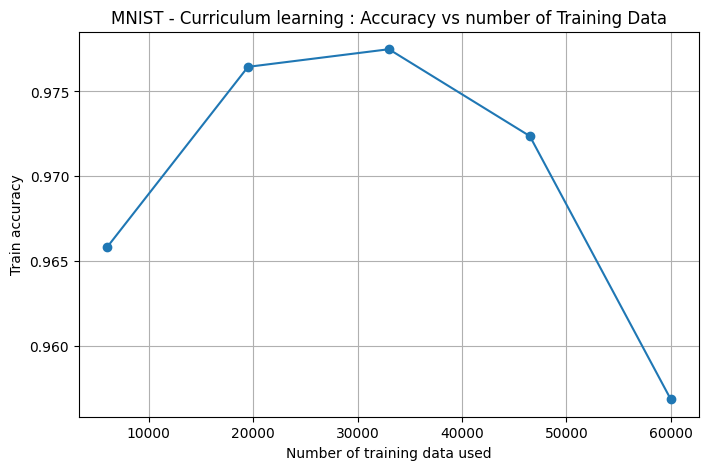

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(num_examples, stage_accs, marker='o')
plt.title("MNIST - Curriculum learning : Accuracy vs number of Training Data")
plt.xlabel("Number of training data used")
plt.ylabel("Train accuracy")
plt.grid(True)
plt.show()

### (2) Self-Paced Learning

In Self-Paced Learning, the model is supposed to:

• learn from easier samples first (based on current loss)

• adaptively expand its training set to include harder samples as it becomes more confident

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
samples_per_epoch = len(X_train)

seen_mask = torch.zeros(len(X_train), dtype=torch.bool)

for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        unseen_indices = (~seen_mask).nonzero(as_tuple=True)[0]
        unseen_loader = DataLoader(TensorDataset(X_train[unseen_indices], y_train[unseen_indices]),
                                   batch_size=batch_size, shuffle=False)

        all_losses = []
        for images, labels in unseen_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)
            all_losses.append(losses.cpu())

        all_losses = torch.cat(all_losses)

    
    k = min(samples_per_epoch, len(unseen_indices))
    selected_in_unseen = torch.topk(-all_losses, k).indices
    selected_indices = unseen_indices[selected_in_unseen]

    seen_mask[selected_indices] = True

    print(f"Epoch {epoch+1}: selected {len(selected_indices)} new samples (total seen: {seen_mask.sum().item()}/{len(X_train)})")

    train_loader = DataLoader(TensorDataset(X_train[selected_indices], y_train[selected_indices]),
                              batch_size=batch_size, shuffle=True)

    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(labels)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_loader.dataset)
    print(f"  Train Loss: {total_loss / len(train_loader.dataset):.4f}, Acc: {acc:.4f}")
    
print("Training complete.")

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

This poor accuracy can be explained because of the cumulative nature of SPL

### (3) Hard-Example Mining

Hard-Example Mining consists in feeding the model only hard examples. In our case, we will consider that a sample is difficult if its normalized difficulty is greater or equal than 0,75 (in other words the top 25%).

In [12]:
accs = []
epochs_list = []

difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

hard_mask = difficulties >= 0.75
hard_indices = np.where(hard_mask)[0] # we do not shuffle the indices to train on increasingly difficult samples (adapted CL idea)
print(f"Selected {len(hard_indices)} hard examples out of {len(difficulties)} total")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10

X_hard = X_train[hard_indices]
y_hard = y_train[hard_indices]

train_dataset = TensorDataset(X_hard, y_hard)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

    accs.append(acc)
    epochs_list.append(epoch + 1)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Selected 337 hard examples out of 60000 total
Epoch 1/10 - Loss: 2.1274, Acc: 0.2493
Epoch 2/10 - Loss: 1.6327, Acc: 0.5134
Epoch 3/10 - Loss: 1.1701, Acc: 0.6202
Epoch 4/10 - Loss: 0.9097, Acc: 0.6973
Epoch 5/10 - Loss: 0.7565, Acc: 0.7596
Epoch 6/10 - Loss: 0.5842, Acc: 0.7953
Epoch 7/10 - Loss: 0.4689, Acc: 0.8338
Epoch 8/10 - Loss: 0.3712, Acc: 0.8783
Epoch 9/10 - Loss: 0.3037, Acc: 0.8872
Epoch 10/10 - Loss: 0.2386, Acc: 0.9318

Final Test Accuracy: 0.4214


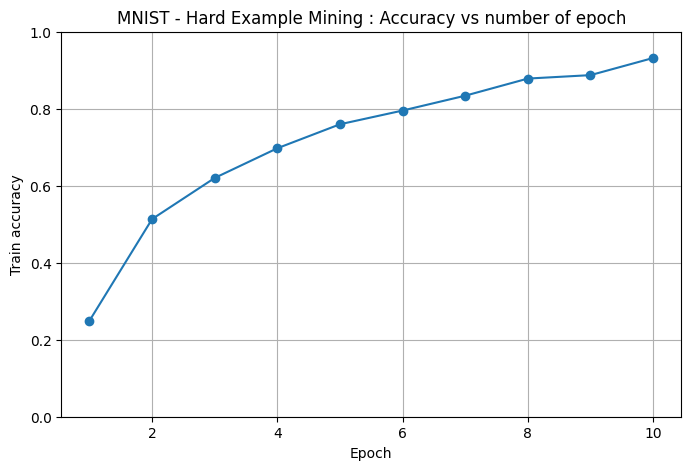

In [13]:
plt.figure(figsize=(8,5))
plt.plot(epochs_list, accs, marker='o')
plt.title("MNIST - Hard Example Mining : Accuracy vs number of epoch")
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

We are implementing **Reverse Curriculum Learning (RCL)** where the model starts learning from easier goals that are close to the target and gradually works backwards to more challenging starting states.

In [14]:
stage_accs = []
num_examples = []

difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

sorted_indices = np.argsort(difficulties)[::-1].copy()  # reverse order for hardest first

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5

phases = np.linspace(0.1, 1.0, num_stages)

previous_n = 0

for stage, phase in enumerate(phases):
    current_n = int(phase * len(sorted_indices))
    selected_idx = sorted_indices[previous_n:current_n]
    previous_n = current_n
    
    print(f"\nStage {stage+1}/{num_stages}: Using {len(selected_idx)} new hard→easy examples")

    X_stage = X_train[selected_idx]
    y_stage = y_train[selected_idx]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        num_examples.append(current_n)


model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Stage 1/5: Using 6000 new hard→easy examples
  Epoch 1/1 - Loss: 0.6989, Acc: 0.7747

Stage 2/5: Using 13500 new hard→easy examples
  Epoch 1/1 - Loss: 0.1274, Acc: 0.9590

Stage 3/5: Using 13500 new hard→easy examples
  Epoch 1/1 - Loss: 0.0618, Acc: 0.9807

Stage 4/5: Using 13500 new hard→easy examples
  Epoch 1/1 - Loss: 0.0251, Acc: 0.9916

Stage 5/5: Using 13500 new hard→easy examples
  Epoch 1/1 - Loss: 0.0048, Acc: 0.9987

Final Test Accuracy: 0.9656


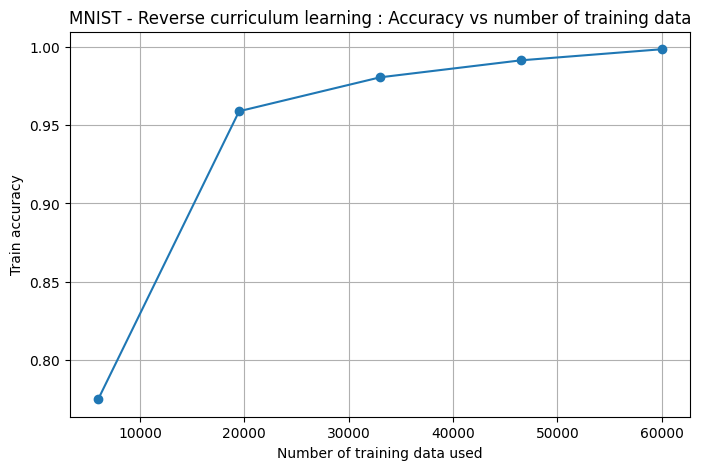

In [15]:
plt.figure(figsize=(8,5))
plt.plot(num_examples, stage_accs, marker='o')
plt.title("MNIST - Reverse curriculum learning : Accuracy vs number of training data")
plt.xlabel("Number of training data used")
plt.ylabel("Train accuracy")
plt.grid(True)
plt.show()

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [16]:
stage_accs = []
num_examples = []
total_seen = 0

difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5
samples_per_stage = int(len(X_train) / num_stages)

num_bins = num_stages
bin_edges = np.linspace(0, 1, num_bins + 1)
bins = [[] for _ in range(num_bins)]

for idx, score in enumerate(difficulties):
    for b in range(num_bins):
        if bin_edges[b] <= score < bin_edges[b + 1] or (b == num_bins - 1 and score == 1.0):
            bins[b].append(idx)
            break

for b in bins:
    np.random.shuffle(b)

seen_indices = set()
num_seen = 0

for stage in range(num_stages):
    
    current_sample_size = len(selected_idx)  
    total_seen += current_sample_size    

    stage_indices = []

    for b in bins:
        take_n = min(samples_per_stage // num_bins, len(b))
        selected = [i for i in b if i not in seen_indices][:take_n]
        seen_indices.update(selected)
        stage_indices.extend(selected)

    np.random.shuffle(stage_indices)

    X_stage = X_train[stage_indices]
    y_stage = y_train[stage_indices]
    num_seen += len(X_stage)

    print(f"\nStage {stage+1}/{num_stages}: Sampling {len(X_stage)} data points from all difficulty strata ({num_seen}/{len(X_train)})")

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")
        stage_accs.append(acc)
        num_examples.append(total_seen)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")




Stage 1/5: Sampling 9724 data points from all difficulty strata (9724/60000)
  Epoch 1/1 - Loss: 0.4835, Acc: 0.8502

Stage 2/5: Sampling 8194 data points from all difficulty strata (17918/60000)
  Epoch 1/1 - Loss: 0.1011, Acc: 0.9696

Stage 3/5: Sampling 4932 data points from all difficulty strata (22850/60000)
  Epoch 1/1 - Loss: 0.0813, Acc: 0.9745

Stage 4/5: Sampling 4800 data points from all difficulty strata (27650/60000)
  Epoch 1/1 - Loss: 0.0798, Acc: 0.9758

Stage 5/5: Sampling 4800 data points from all difficulty strata (32450/60000)
  Epoch 1/1 - Loss: 0.0649, Acc: 0.9781

Final Test Accuracy: 0.9786


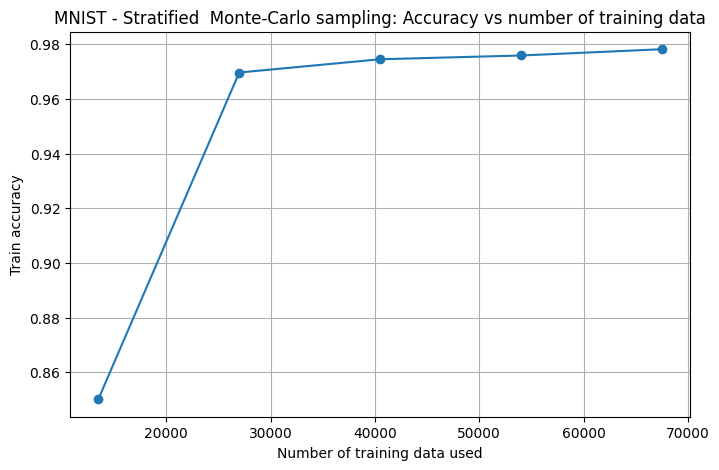

In [17]:
plt.figure(figsize=(8,5))
plt.plot(num_examples, stage_accs, marker='o')
plt.title("MNIST - Stratified  Monte-Carlo sampling: Accuracy vs number of training data")
plt.xlabel("Number of training data used")
plt.ylabel("Train accuracy")
plt.grid(True)
plt.show()

# MNIST Dataset with Gaussian Noise

## Data Loading

We initialize a range of increasing difficulty. 
- 0.0: no noise — easiest samples
- 0.4: very noisy — hardest samples
- 0.5+ usually makes MNIST unreadable

In [18]:
# Load base MNIST (no transform)
base_train = datasets.MNIST(root='./data', train=True, download=True)
base_test = datasets.MNIST(root='./data', train=False, download=True)

full_data = torch.cat([base_train.data, base_test.data], dim=0).float() / 255.0
full_targets = torch.cat([base_train.targets, base_test.targets], dim=0)

# Expand with noise
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]
augmented_data, augmented_targets, noise_labels = [], [], []

for level in noise_levels:
    noise = torch.randn_like(full_data) * level
    noisy_data = full_data + noise
    noisy_data = torch.clamp(noisy_data, 0.0, 1.0)

    augmented_data.append(noisy_data)
    augmented_targets.append(full_targets)
    noise_labels.append(torch.full_like(full_targets, level))

# Combine everything
augmented_data = torch.cat(augmented_data, dim=0).unsqueeze(1)  # (N*L, 1, 28, 28)
augmented_targets = torch.cat(augmented_targets, dim=0)
noise_labels = torch.cat(noise_labels, dim=0)

# Final dataset
augmented_dataset = TensorDataset(augmented_data, augmented_targets, noise_labels)

In [19]:
N_train = len(base_train)  # 60000
N_test = len(base_test)    # 10000

samples_per_level = N_train + N_test

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for i in range(len(noise_levels)):
    start = i * samples_per_level
    end = start + samples_per_level

    X_level = augmented_data[start:end]
    y_level = augmented_targets[start:end]

    X_train_list.append(X_level[:N_train])
    y_train_list.append(y_level[:N_train])
    X_test_list.append(X_level[N_train:])
    y_test_list.append(y_level[N_train:])

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: torch.Size([300000, 1, 28, 28]), y_train: torch.Size([300000])
X_test: torch.Size([50000, 1, 28, 28]), y_test: torch.Size([50000])


In [20]:
noise_levels_train_list = []

for i, level in enumerate(noise_levels):
    num_train_samples = N_train
    noise_level_tensor = torch.full((num_train_samples,), fill_value=i)
    
    noise_levels_train_list.append(noise_level_tensor)

noise_levels_train = torch.cat(noise_levels_train_list, dim=0)

print(f"noise_levels_train shape: {noise_levels_train.shape}")


noise_levels_train shape: torch.Size([300000])


## Analysis

### (0) Base Case

In [21]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # random sampling baseline
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f}, Train Acc: {train_acc:.4f}")

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/1 - Train Loss: 0.0832, Train Acc: 0.9740
Test Accuracy: 0.9846


### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [22]:
stage_accs = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels <= {stage}")
    
    stage_mask = noise_levels_train <= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        num_examples.append(np.sum([len(X_train[noise_levels_train <= s]) for s in range(stage+1)]))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise levels <= 0
  Epoch 1/1 - Loss: 0.1729, Acc: 0.9486

Stage 2/5: Using noise levels <= 1
  Epoch 1/1 - Loss: 0.0411, Acc: 0.9872

Stage 3/5: Using noise levels <= 2
  Epoch 1/1 - Loss: 0.0226, Acc: 0.9927

Stage 4/5: Using noise levels <= 3
  Epoch 1/1 - Loss: 0.0164, Acc: 0.9945

Stage 5/5: Using noise levels <= 4
  Epoch 1/1 - Loss: 0.0176, Acc: 0.9940

Final Test Accuracy: 0.9887


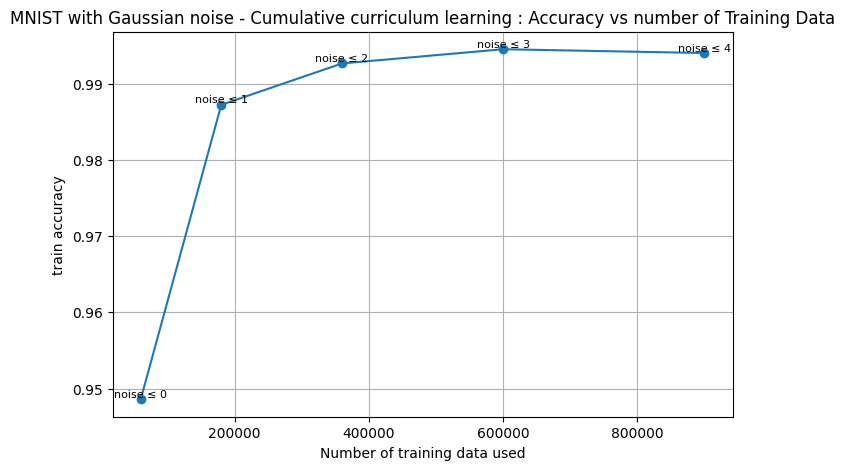

In [23]:
plt.figure(figsize=(8,5))
plt.plot(num_examples, stage_accs, marker='o')
plt.title("MNIST with Gaussian noise - Cumulative curriculum learning : Accuracy vs number of Training Data")
plt.xlabel("Number of training data used")
plt.ylabel("train accuracy")
plt.grid(True)
for i, (x, y) in enumerate(zip(num_examples, stage_accs)):
    plt.text(x, y, f"noise ≤ {i}", fontsize=8, ha='center', va='bottom')
plt.show()

#### (1.2) Strict Curriculum Learning

In [24]:
stage_accs = []
noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        noise_levels.append(stage)
        num_examples.append(len(X_stage))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.1762, Acc: 0.9454

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0511, Acc: 0.9843

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0429, Acc: 0.9863

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.0444, Acc: 0.9862

Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.0610, Acc: 0.9800

Final Test Accuracy: 0.9847


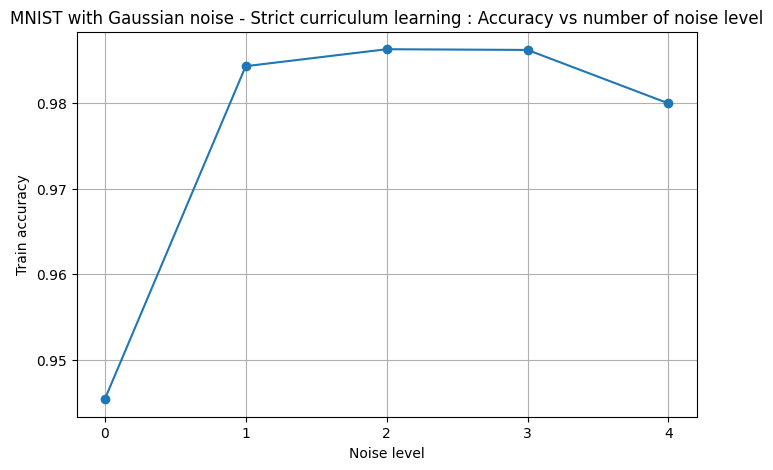

In [25]:
plt.figure(figsize=(8,5))
plt.plot(noise_levels, stage_accs, marker='o')
plt.title("MNIST with Gaussian noise - Strict curriculum learning : Accuracy vs number of noise level")
plt.xlabel("Noise level")
plt.ylabel("Train accuracy")
plt.xticks(noise_levels)
plt.grid(True)
plt.show()

### (2) Self-Paced Learning

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

Because our objective is to see the influence of order on the training, we will stop training once the model saw the entire dataset. To be fair with the other techniques where they see the data only once.

In [26]:
train_accs = []
epochs_list = []
num_selected = []
lambda_values = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10
initial_lambda = 2.25  # initial difficulty threshold
lambda_increment = 2  # increase per epoch

full_train_dataset = TensorDataset(X_train, y_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.eval()
    all_losses = []

    with torch.no_grad():
        for images, labels in full_train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)
            all_losses.append(losses.cpu())

    all_losses = torch.cat(all_losses)
    print(torch.min(all_losses))
    print(torch.max(all_losses))

    lambda_threshold = initial_lambda + epoch * lambda_increment

    selected_indices = (all_losses <= lambda_threshold).nonzero(as_tuple=True)[0]

    if len(selected_indices) == 0:
        print(f"Epoch {epoch+1}: No samples selected for training (lambda={lambda_threshold:.3f}), stopping early.")
        break

    print(f"Epoch {epoch+1}: lambda={lambda_threshold:.3f}, selected {len(selected_indices)}/{len(X_train)} samples")

    train_subset = TensorDataset(X_train[selected_indices], y_train[selected_indices])
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_subset)
    print(f"  Training Loss: {total_loss/len(train_subset):.4f}, Accuracy: {acc:.4f}")
    
    train_accs.append(acc)
    epochs_list.append(epoch + 1)
    num_selected.append(len(selected_indices))
    lambda_values.append(lambda_threshold)

    if len(selected_indices) == len(X_train):
        print(f"  All samples were selected, stopping early.")
        break

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


tensor(2.2141)
tensor(2.3969)
Epoch 1: lambda=2.250, selected 12482/300000 samples
  Training Loss: 0.1898, Accuracy: 0.9555
tensor(-0.)
tensor(23.5694)
Epoch 2: lambda=4.250, selected 55347/300000 samples
  Training Loss: 0.0201, Accuracy: 0.9927
tensor(-0.)
tensor(35.4047)
Epoch 3: lambda=6.250, selected 56702/300000 samples
  Training Loss: 0.0161, Accuracy: 0.9944
tensor(-0.)
tensor(54.8456)
Epoch 4: lambda=8.250, selected 73129/300000 samples
  Training Loss: 0.0163, Accuracy: 0.9947
tensor(-0.)
tensor(61.7653)
Epoch 5: lambda=10.250, selected 129375/300000 samples
  Training Loss: 0.0323, Accuracy: 0.9901
tensor(-0.)
tensor(52.8322)
Epoch 6: lambda=12.250, selected 269455/300000 samples
  Training Loss: 0.0352, Accuracy: 0.9887
tensor(-0.)
tensor(33.7344)
Epoch 7: lambda=14.250, selected 299887/300000 samples
  Training Loss: 0.0222, Accuracy: 0.9929
tensor(-0.)
tensor(34.3698)
Epoch 8: lambda=16.250, selected 299981/300000 samples
  Training Loss: 0.0128, Accuracy: 0.9957
tensor

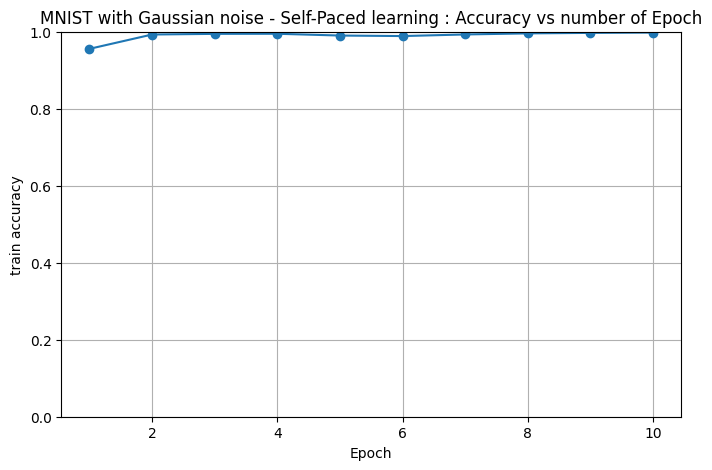

In [27]:
plt.figure(figsize=(8,5))
plt.plot(epochs_list, train_accs, marker='o')
plt.title("MNIST with Gaussian noise - Self-Paced learning : Accuracy vs number of Epoch")
plt.xlabel("Epoch")
plt.ylabel("train accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

An idea could be to combine the difficulty scores from the noise levels with the increments in SLP:


**Option A: Use Noise Difficulty as a Prior or Weight for Lambda Threshold**

- Adjust the SPL threshold (`λ`) for each sample by incorporating its noise difficulty:

\[
\lambda_i = \lambda_{\text{base}} + \alpha \times \text{noise\_level}_i
\]

- Samples with higher noise difficulty require a higher loss to be included, effectively entering the curriculum later.

**Option B: Use Noise Difficulty for Initial Sample Filtering**

- Start SPL training using only samples with noise difficulty below a certain threshold (e.g., noise_level ≤ 0.2).
- Gradually expand the training set to include samples with higher noise difficulty as training progresses.

**Option C: Weighted Loss or Thresholding by Noise Difficulty Quantiles**

- Group samples by their noise difficulty levels.
- Compute separate SPL loss thresholds for each noise group.
- Allow lower thresholds (easier inclusion) for low-noise groups and higher thresholds for high-noise groups.
- This respects both the *a priori* noise difficulty and the *dynamic* training loss.

### (3) Hard-Example Mining

In [28]:
train_accs = []
epochs_list = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 5

# Define what "hard" means: top 1 or 2 noise levels (e.g., 0.3 and 0.4)
# If noise_levels_train goes from 0 to 4 (for noise 0.0 to 0.4), we can take levels >= 3
hard_mask = noise_levels_train >= 3


X_hard = X_train[hard_mask]
y_hard = y_train[hard_mask]
print(f"Selected {len(X_hard)} hard examples out of {len(X_train)}")

hard_dataset = TensorDataset(X_hard, y_hard)
hard_loader = DataLoader(hard_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in hard_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(hard_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(hard_dataset):.4f}, Accuracy: {acc:.4f}")

    train_accs.append(acc)
    epochs_list.append(epoch + 1)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Selected 120000 hard examples out of 300000
Epoch 1/5 - Loss: 0.1866, Accuracy: 0.9422
Epoch 2/5 - Loss: 0.0618, Accuracy: 0.9801
Epoch 3/5 - Loss: 0.0418, Accuracy: 0.9860
Epoch 4/5 - Loss: 0.0296, Accuracy: 0.9903
Epoch 5/5 - Loss: 0.0221, Accuracy: 0.9922

Final Test Accuracy: 0.9866


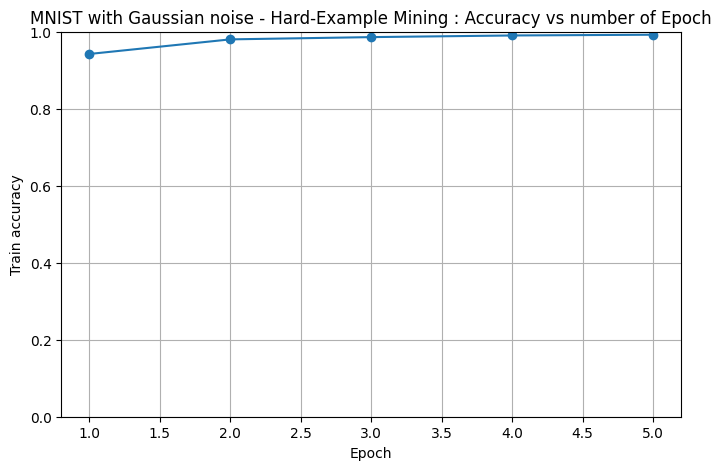

In [29]:
plt.figure(figsize=(8,5))
plt.plot(epochs_list, train_accs, marker='o')
plt.title("MNIST with Gaussian noise - Hard-Example Mining : Accuracy vs number of Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [30]:
stage_accs = []
min_noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1 
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels >= {stage}")
    
    stage_mask = noise_levels_train >= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        min_noise_levels.append(stage)
        num_examples.append(len(X_stage))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise levels >= 4


  Epoch 1/1 - Loss: 0.3244, Acc: 0.8979

Stage 4/5: Using noise levels >= 3
  Epoch 1/1 - Loss: 0.0824, Acc: 0.9734

Stage 3/5: Using noise levels >= 2
  Epoch 1/1 - Loss: 0.0451, Acc: 0.9855

Stage 2/5: Using noise levels >= 1
  Epoch 1/1 - Loss: 0.0260, Acc: 0.9912

Stage 1/5: Using noise levels >= 0
  Epoch 1/1 - Loss: 0.0161, Acc: 0.9946

Final Test Accuracy: 0.9880


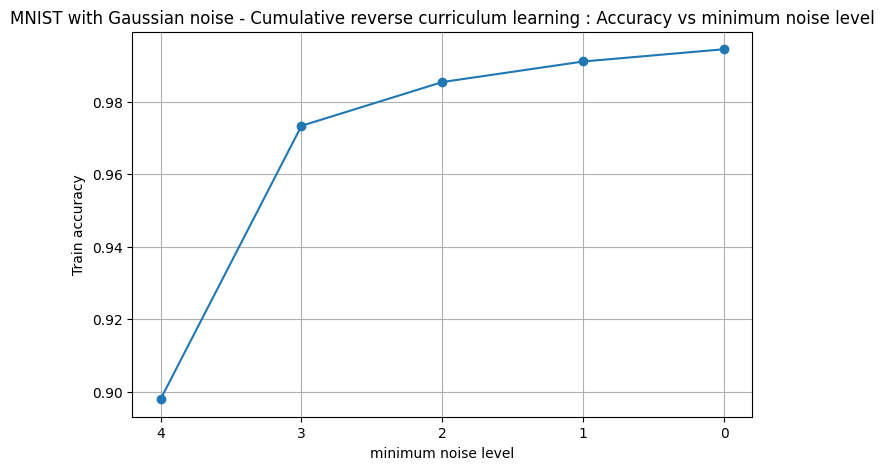

In [31]:
plt.figure(figsize=(8,5))
plt.plot(min_noise_levels, stage_accs, marker='o')
plt.title("MNIST with Gaussian noise - Cumulative reverse curriculum learning : Accuracy vs minimum noise level")
plt.xlabel("minimum noise level")
plt.ylabel("Train accuracy")
plt.xticks(min_noise_levels)  # Pour afficher 0, 1, 2, 3, 4
plt.gca().invert_xaxis()      # Pour afficher du plus bruité vers le moins bruité (optionnel mais pertinent ici)
plt.grid(True)
plt.show()

#### (4.2) Strict Reverse Curriculum Learning

In [32]:
stage_accs = []
noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        noise_levels.append(stage)
        num_examples.append(len(X_stage))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.2757, Acc: 0.9151

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.0771, Acc: 0.9762

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0463, Acc: 0.9855

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0323, Acc: 0.9896

Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.0251, Acc: 0.9920

Final Test Accuracy: 0.9794


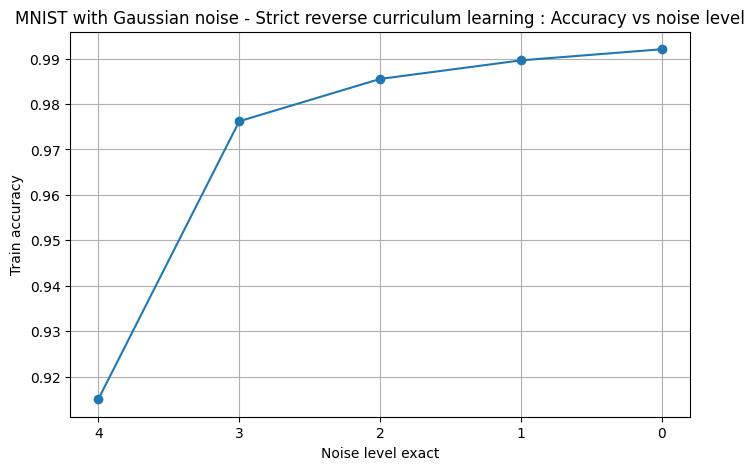

In [33]:
plt.figure(figsize=(8,5))
plt.plot(noise_levels, stage_accs, marker='o')
plt.title("MNIST with Gaussian noise - Strict reverse curriculum learning : Accuracy vs noise level")
plt.xlabel("Noise level exact")
plt.ylabel("Train accuracy")
plt.xticks(noise_levels)
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [34]:
stage_accs = []
noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1 
num_stages = 5
samples_per_stage = 10000

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Sampling from stage level = {stage}")
    
    stage_mask = (noise_levels_train == stage).nonzero(as_tuple=True)[0]
    
    # Randomly sample without replacement
    if len(stage_mask) < samples_per_stage:
        print(f"  Warning: only {len(stage_mask)} samples available, using all.")
        selected_indices = stage_mask
    else:
        selected_indices = stage_mask[torch.randperm(len(stage_mask))[:samples_per_stage]]
    
    X_stage = X_train[selected_indices]
    y_stage = y_train[selected_indices]
    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        noise_levels.append(stage)
        num_examples.append(len(train_dataset))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Stage 1/5: Sampling from stage level = 0
  Epoch 1/1 - Loss: 0.5551, Acc: 0.8353

Stage 2/5: Sampling from stage level = 1
  Epoch 1/1 - Loss: 0.1538, Acc: 0.9549

Stage 3/5: Sampling from stage level = 2
  Epoch 1/1 - Loss: 0.1325, Acc: 0.9599

Stage 4/5: Sampling from stage level = 3
  Epoch 1/1 - Loss: 0.1232, Acc: 0.9616

Stage 5/5: Sampling from stage level = 4
  Epoch 1/1 - Loss: 0.1460, Acc: 0.9552

Final Test Accuracy: 0.9739


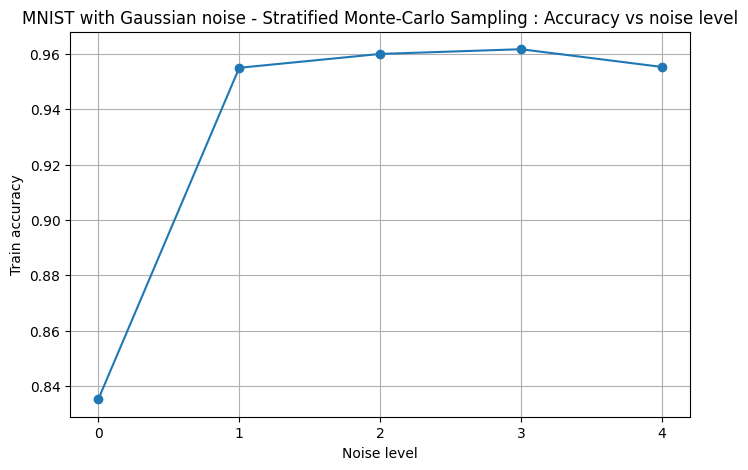

In [35]:
plt.figure(figsize=(8,5))
plt.plot(noise_levels, stage_accs, marker='o')
plt.title("MNIST with Gaussian noise - Stratified Monte-Carlo Sampling : Accuracy vs noise level")
plt.xlabel("Noise level")
plt.ylabel("Train accuracy")
plt.xticks(noise_levels)
plt.grid(True)
plt.show()

# MNIST Dataset with Impulse Noise

## Data Loading

We initialize a range of increasing difficulty. 
- 0.0: no noise — easiest samples
- 0.4: very noisy — hardest samples
- 0.5+ usually makes MNIST unreadable

In [36]:
base_train = datasets.MNIST(root='./data', train=True, download=True)
base_test = datasets.MNIST(root='./data', train=False, download=True)

full_data = torch.cat([base_train.data, base_test.data], dim=0).float() / 255.0
full_targets = torch.cat([base_train.targets, base_test.targets], dim=0)

noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]

augmented_data, augmented_targets, noise_labels = [], [], []

for level in noise_levels:
    noisy_data = full_data.clone()
    if level > 0:
        N, H, W = noisy_data.shape
        total_pixels = H * W

        num_noisy = int(level * total_pixels)

        for i in range(N):
            coords = torch.randperm(total_pixels)[:num_noisy]
            salt_or_pepper = torch.randint(0, 2, (num_noisy,), dtype=torch.float32)  # 0 or 1
            flat_image = noisy_data[i].view(-1)
            flat_image[coords] = salt_or_pepper

    augmented_data.append(noisy_data)
    augmented_targets.append(full_targets)
    noise_labels.append(torch.full_like(full_targets, fill_value=level))

augmented_data = torch.cat(augmented_data, dim=0).unsqueeze(1)
augmented_targets = torch.cat(augmented_targets, dim=0)
noise_labels = torch.cat(noise_labels, dim=0)

N_train = len(base_train)
N_test = len(base_test)
samples_per_level = N_train + N_test

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for i in range(len(noise_levels)):
    start = i * samples_per_level
    end = start + samples_per_level

    X_level = augmented_data[start:end]
    y_level = augmented_targets[start:end]

    X_train_list.append(X_level[:N_train])
    y_train_list.append(y_level[:N_train])
    X_test_list.append(X_level[N_train:])
    y_test_list.append(y_level[N_train:])

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

noise_levels_train_list = []

for i, level in enumerate(noise_levels):
    noise_level_tensor = torch.full((N_train,), fill_value=i)
    noise_levels_train_list.append(noise_level_tensor)

noise_levels_train = torch.cat(noise_levels_train_list, dim=0)
print(f"noise_levels_train shape: {noise_levels_train.shape}")


X_train: torch.Size([300000, 1, 28, 28]), y_train: torch.Size([300000])
X_test: torch.Size([50000, 1, 28, 28]), y_test: torch.Size([50000])
noise_levels_train shape: torch.Size([300000])


## Analysis

### (0) Base Case

In [37]:
# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # random sampling baseline
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f}, Train Acc: {train_acc:.4f}")

# Evaluate
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/1 - Train Loss: 0.1372, Train Acc: 0.9561
Test Accuracy: 0.9760


### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [38]:
stage_accs = []
max_noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels <= {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train <= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        max_noise_levels.append(stage)
        num_examples.append(len(train_dataset))

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise levels <= 0
  Epoch 1/1 - Loss: 0.1915, Acc: 0.9414

Stage 2/5: Using noise levels <= 1
  Epoch 1/1 - Loss: 0.0561, Acc: 0.9826

Stage 3/5: Using noise levels <= 2
  Epoch 1/1 - Loss: 0.0396, Acc: 0.9871

Stage 4/5: Using noise levels <= 3
  Epoch 1/1 - Loss: 0.0391, Acc: 0.9873

Stage 5/5: Using noise levels <= 4
  Epoch 1/1 - Loss: 0.0476, Acc: 0.9843

Final Test Accuracy: 0.9813


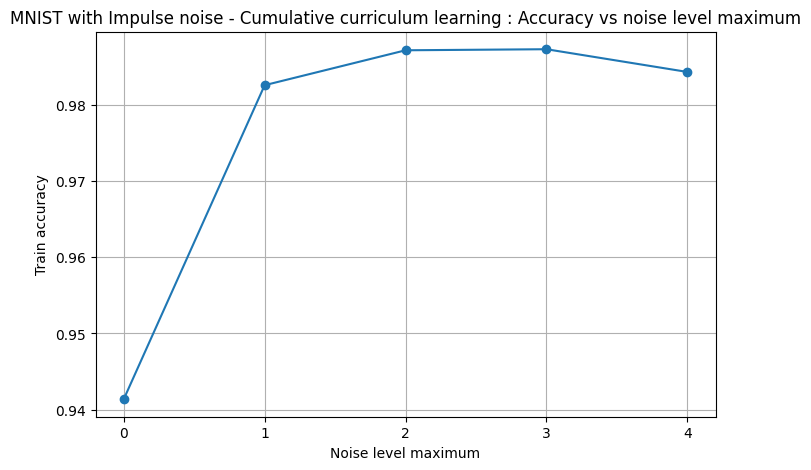

In [39]:
plt.figure(figsize=(8,5))
plt.plot(max_noise_levels, stage_accs, marker='o')
plt.title("MNIST with Impulse noise - Cumulative curriculum learning : Accuracy vs noise level maximum")
plt.xlabel("Noise level maximum")
plt.ylabel("Train accuracy")
plt.xticks(max_noise_levels)
plt.grid(True)
plt.show()

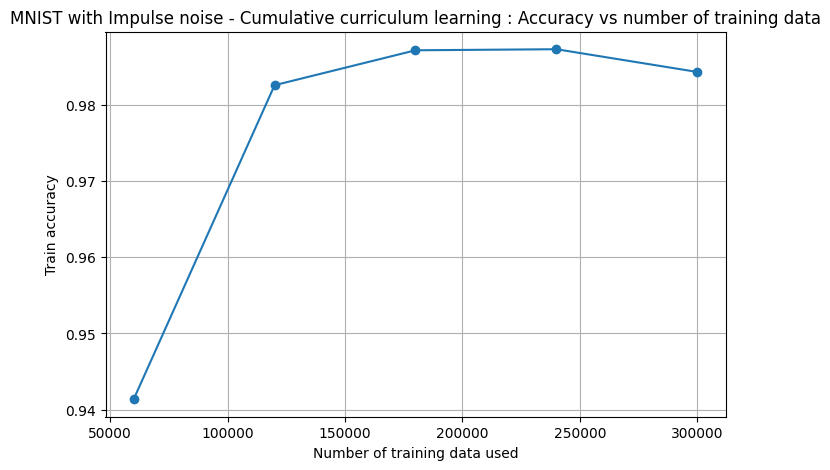

In [40]:
plt.figure(figsize=(8,5))
plt.plot(num_examples, stage_accs, marker='o')
plt.title("MNIST with Impulse noise - Cumulative curriculum learning : Accuracy vs number of training data")
plt.xlabel("Number of training data used")
plt.ylabel("Train accuracy")
plt.grid(True)
plt.show()

#### (1.2) Strict Curriculum Learning

In [41]:
stage_accs = []
noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        noise_levels.append(stage)
        num_examples.append(len(train_dataset))

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.1785, Acc: 0.9459

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0738, Acc: 0.9773

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0737, Acc: 0.9762

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.1057, Acc: 0.9660

Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.1553, Acc: 0.9483

Final Test Accuracy: 0.9752


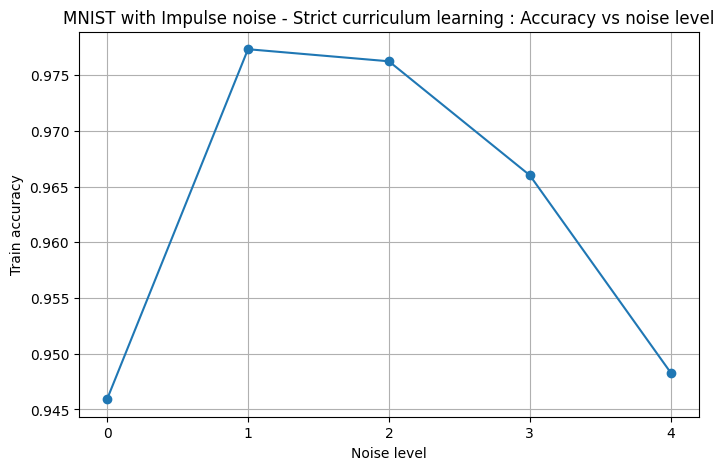

In [42]:
plt.figure(figsize=(8,5))
plt.plot(noise_levels, stage_accs, marker='o')
plt.title("MNIST with Impulse noise - Strict curriculum learning : Accuracy vs noise level")
plt.xlabel("Noise level")
plt.ylabel("Train accuracy")
plt.xticks(noise_levels)
plt.grid(True)
plt.show()

### (2) Self-Paced Learning

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

Because our objective is to see the influence of order on the training, we will stop training once the model saw the entire dataset. To be fair with the other techniques where they see the data only once.

In [44]:
train_accs = []
epochs_list = []
num_selected = []
lambda_values = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')  # Important: per-sample loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10
initial_lambda = 2.25  # initial difficulty threshold
lambda_increment = 2  # increase per epoch

# Wrap all training data in a dataset/loader for loss evaluation
full_train_dataset = TensorDataset(X_train, y_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.eval()
    all_losses = []

    # Compute per-sample losses on the full training set
    with torch.no_grad():
        for images, labels in full_train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)  # shape: (batch_size,)
            all_losses.append(losses.cpu())

    all_losses = torch.cat(all_losses)  # shape: (N,)
    print(torch.min(all_losses))
    print(torch.max(all_losses))

    # Determine current lambda threshold
    lambda_threshold = initial_lambda + epoch * lambda_increment

    # Select indices where loss <= lambda_threshold
    selected_indices = (all_losses <= lambda_threshold).nonzero(as_tuple=True)[0]

    if len(selected_indices) == 0:
        print(f"Epoch {epoch+1}: No samples selected for training (lambda={lambda_threshold:.3f}), stopping early.")
        break

    print(f"Epoch {epoch+1}: lambda={lambda_threshold:.3f}, selected {len(selected_indices)}/{len(X_train)} samples")

    # Create subset dataset and loader for training
    train_subset = TensorDataset(X_train[selected_indices], y_train[selected_indices])
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Train on selected samples
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()  # mean loss for batch
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_subset)
    print(f"  Training Loss: {total_loss/len(train_subset):.4f}, Accuracy: {acc:.4f}")

    train_accs.append(acc)
    epochs_list.append(epoch + 1)
    num_selected.append(len(selected_indices))
    lambda_values.append(lambda_threshold)


    if len(selected_indices) == len(X_train):
        print(f"  All samples were selected, stopping early.")
        break

# Evaluate on test set after training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


tensor(2.1737)
tensor(2.4730)
Epoch 1: lambda=2.250, selected 84617/300000 samples
  Training Loss: 0.0724, Accuracy: 0.9763
tensor(-0.)
tensor(36.8572)
Epoch 2: lambda=4.250, selected 128676/300000 samples
  Training Loss: 0.0228, Accuracy: 0.9923
tensor(-0.)
tensor(48.6515)
Epoch 3: lambda=6.250, selected 148232/300000 samples
  Training Loss: 0.0252, Accuracy: 0.9913
tensor(-0.)
tensor(49.7651)
Epoch 4: lambda=8.250, selected 202035/300000 samples
  Training Loss: 0.0395, Accuracy: 0.9875
tensor(-0.)
tensor(33.8426)
Epoch 5: lambda=10.250, selected 277504/300000 samples
  Training Loss: 0.0482, Accuracy: 0.9841
tensor(-0.)
tensor(38.1078)
Epoch 6: lambda=12.250, selected 299874/300000 samples
  Training Loss: 0.0406, Accuracy: 0.9864
tensor(-0.)
tensor(32.5645)
Epoch 7: lambda=14.250, selected 299994/300000 samples
  Training Loss: 0.0262, Accuracy: 0.9912
tensor(-0.)
tensor(35.2192)
Epoch 8: lambda=16.250, selected 299995/300000 samples
  Training Loss: 0.0186, Accuracy: 0.9936
ten

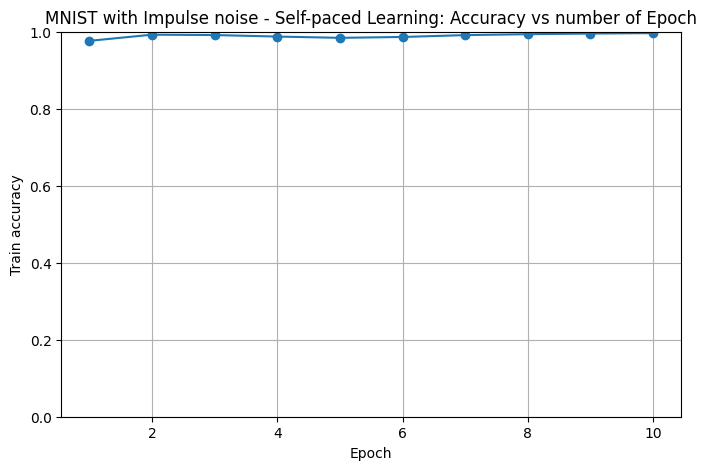

In [45]:
plt.figure(figsize=(8,5))
plt.plot(epochs_list, train_accs, marker='o')
plt.title("MNIST with Impulse noise - Self-paced Learning: Accuracy vs number of Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

An idea could be to combine the difficulty scores from the noise levels with the increments in SLP:


**Option A: Use Noise Difficulty as a Prior or Weight for Lambda Threshold**

- Adjust the SPL threshold (`λ`) for each sample by incorporating its noise difficulty:

\[
\lambda_i = \lambda_{\text{base}} + \alpha \times \text{noise\_level}_i
\]

- Samples with higher noise difficulty require a higher loss to be included, effectively entering the curriculum later.

**Option B: Use Noise Difficulty for Initial Sample Filtering**

- Start SPL training using only samples with noise difficulty below a certain threshold (e.g., noise_level ≤ 0.2).
- Gradually expand the training set to include samples with higher noise difficulty as training progresses.

**Option C: Weighted Loss or Thresholding by Noise Difficulty Quantiles**

- Group samples by their noise difficulty levels.
- Compute separate SPL loss thresholds for each noise group.
- Allow lower thresholds (easier inclusion) for low-noise groups and higher thresholds for high-noise groups.
- This respects both the *a priori* noise difficulty and the *dynamic* training loss.

### (3) Hard-Example Mining

In [46]:
train_accs = []
epochs_list = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 5

# Define what "hard" means: top 1 or 2 noise levels (e.g., 0.3 and 0.4)
# If noise_levels_train goes from 0 to 4 (for noise 0.0 to 0.4), we can take levels >= 3
hard_mask = noise_levels_train >= 3

# Select hard examples
X_hard = X_train[hard_mask]
y_hard = y_train[hard_mask]
print(f"Selected {len(X_hard)} hard examples out of {len(X_train)}")

# Wrap in dataset and loader
hard_dataset = TensorDataset(X_hard, y_hard)
hard_loader = DataLoader(hard_dataset, batch_size=batch_size, shuffle=True)

# Training loop on hard examples
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in hard_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(hard_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(hard_dataset):.4f}, Accuracy: {acc:.4f}")

    train_accs.append(acc)
    epochs_list.append(epoch + 1)

# Final test evaluation
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Selected 120000 hard examples out of 300000
Epoch 1/5 - Loss: 0.3285, Accuracy: 0.8953
Epoch 2/5 - Loss: 0.1450, Accuracy: 0.9533
Epoch 3/5 - Loss: 0.1084, Accuracy: 0.9642
Epoch 4/5 - Loss: 0.0863, Accuracy: 0.9713
Epoch 5/5 - Loss: 0.0711, Accuracy: 0.9762

Final Test Accuracy: 0.9783


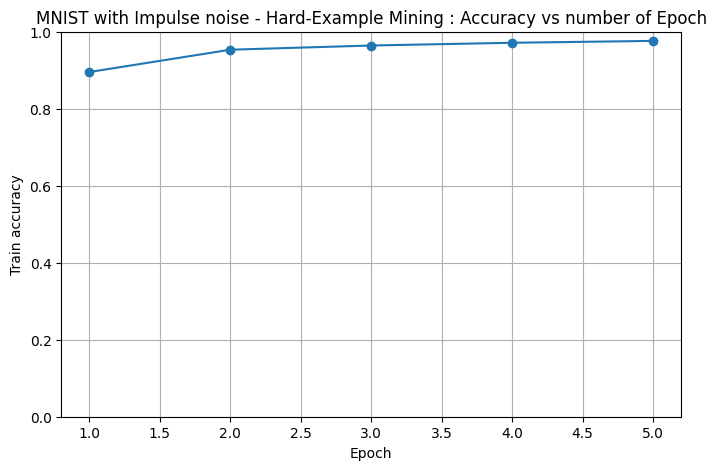

In [47]:
plt.figure(figsize=(8,5))
plt.plot(epochs_list, train_accs, marker='o')
plt.title("MNIST with Impulse noise - Hard-Example Mining : Accuracy vs number of Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [48]:
stage_accs = []
min_noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels >= {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train >= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        min_noise_levels.append(stage)
        num_examples.append(len(train_dataset))

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise levels >= 4
  Epoch 1/1 - Loss: 0.4862, Acc: 0.8438

Stage 4/5: Using noise levels >= 3
  Epoch 1/1 - Loss: 0.1676, Acc: 0.9457

Stage 3/5: Using noise levels >= 2
  Epoch 1/1 - Loss: 0.0996, Acc: 0.9675

Stage 2/5: Using noise levels >= 1
  Epoch 1/1 - Loss: 0.0651, Acc: 0.9789

Stage 1/5: Using noise levels >= 0
  Epoch 1/1 - Loss: 0.0442, Acc: 0.9853

Final Test Accuracy: 0.9807


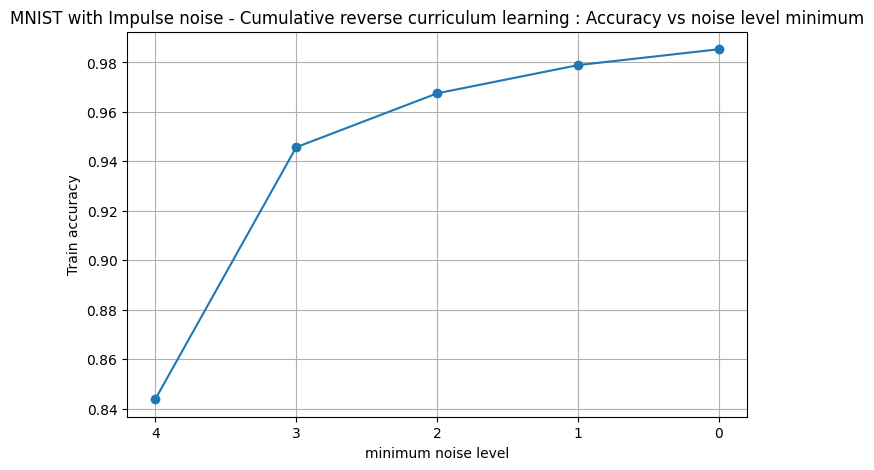

In [49]:
plt.figure(figsize=(8,5))
plt.plot(min_noise_levels, stage_accs, marker='o')
plt.title("MNIST with Impulse noise - Cumulative reverse curriculum learning : Accuracy vs noise level minimum")
plt.xlabel("minimum noise level")
plt.ylabel("Train accuracy")
plt.xticks(min_noise_levels)
plt.gca().invert_xaxis()  # pour afficher de hard (4) à easy (0)
plt.grid(True)
plt.show()

#### (4.2) Strict Reverse Curriculum Learning

In [50]:
stage_accs = []
noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        noise_levels.append(stage)
        num_examples.append(len(train_dataset))


# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.4637, Acc: 0.8510

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.1427, Acc: 0.9546

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0775, Acc: 0.9750

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0507, Acc: 0.9840

Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.0319, Acc: 0.9898

Final Test Accuracy: 0.9582


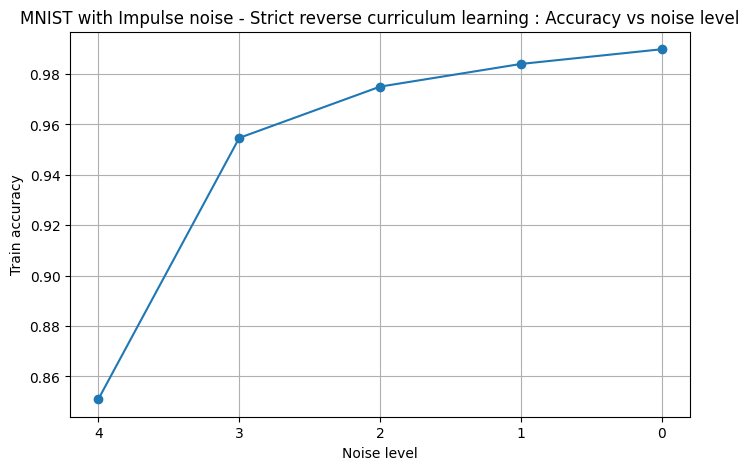

In [51]:
plt.figure(figsize=(8,5))
plt.plot(noise_levels, stage_accs, marker='o')
plt.title("MNIST with Impulse noise - Strict reverse curriculum learning : Accuracy vs noise level")
plt.xlabel("Noise level")
plt.ylabel("Train accuracy")
plt.xticks(noise_levels)
plt.gca().invert_xaxis()  # Affiche 4,3,2,1,0 dans l'ordre hard→easy
plt.grid(True)
plt.show()

### (5) Stratified Monte-Carlo Sampling

In [52]:
stage_accs = []
noise_levels = []
num_examples = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # same as curriculum
num_stages = 5        # noise levels 0–4
samples_per_stage = 10000  # number of examples to sample from each difficulty level

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Sampling from noise level = {stage}")
    
    # Select indices for current noise level
    stage_mask = (noise_levels_train == stage).nonzero(as_tuple=True)[0]
    
    # Randomly sample without replacement
    if len(stage_mask) < samples_per_stage:
        print(f"  Warning: only {len(stage_mask)} samples available, using all.")
        selected_indices = stage_mask
    else:
        selected_indices = stage_mask[torch.randperm(len(stage_mask))[:samples_per_stage]]
    
    # Prepare subset
    X_stage = X_train[selected_indices]
    y_stage = y_train[selected_indices]
    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs.append(acc)
        noise_levels.append(stage)
        num_examples.append(len(train_dataset))


# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Stage 1/5: Sampling from noise level = 0
  Epoch 1/1 - Loss: 0.6252, Acc: 0.8075

Stage 2/5: Sampling from noise level = 1
  Epoch 1/1 - Loss: 0.2200, Acc: 0.9342

Stage 3/5: Sampling from noise level = 2
  Epoch 1/1 - Loss: 0.1776, Acc: 0.9434

Stage 4/5: Sampling from noise level = 3
  Epoch 1/1 - Loss: 0.2109, Acc: 0.9329

Stage 5/5: Sampling from noise level = 4
  Epoch 1/1 - Loss: 0.2759, Acc: 0.9146

Final Test Accuracy: 0.9556


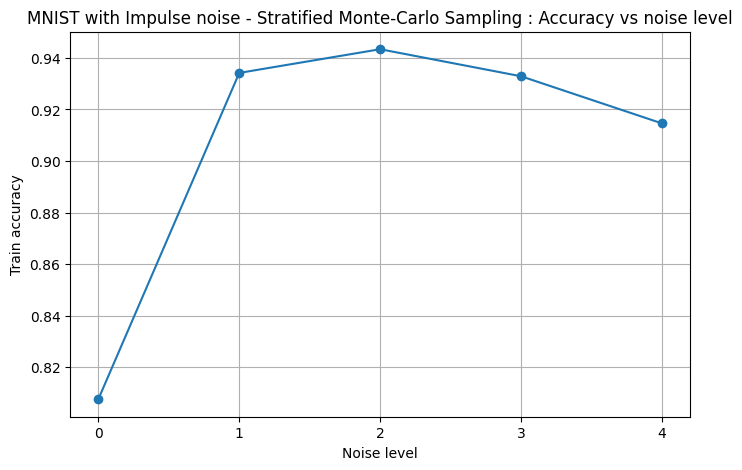

In [53]:
plt.figure(figsize=(8,5))
plt.plot(noise_levels, stage_accs, marker='o')
plt.title("MNIST with Impulse noise - Stratified Monte-Carlo Sampling : Accuracy vs noise level")
plt.xlabel("Noise level")
plt.ylabel("Train accuracy")
plt.xticks(noise_levels)
plt.grid(True)
plt.show()